# Task 1

## Importing Packages and Investigating the AOI File

In [1]:
# Importing all the Necessary Packages

import os
import geopandas as gpd
import fiona
from keplergl import KeplerGl
import rasterio
from rasterio.plot import show
from matplotlib import pyplot as plt
import rasterio as rio
import pycrs

In [2]:
# Importing the Area of Interest to investigate the file 

folder_path = 'data'
file_name = 'remote_sensing_challenge_AOI.geojson'

file_path = os.path.join(folder_path, file_name)
aoi_data = gpd.read_file(file_path, driver = 'GeoJSON')
aoi_data

,id,full_id,osm_id,osm_type,cables,frequency,gez,layer,name,operator,power,ref,voltage,wires,line,disused,circuits,location,endpoint:busbar,geometry
0,1,w166885638,166885638,way,3,50,,,,Stromnetz Berlin,line,806,110000,single,,,,,,"MULTIPOLYGON (((13.53442 52.53548, 13.53289 52..."


In [3]:
def assertCRSValues(crs1,crs2):    
    # Method to assert the CRS Values 
    
    assert crs1 == crs2, 'CRS Values are not matching, please reproject to maintain similar CRS!'

In [4]:
aoi_data.dtypes

id                    int64
full_id              object
osm_id               object
osm_type             object
cables               object
frequency            object
gez                  object
layer                object
name                 object
operator             object
power                object
ref                  object
voltage              object
wires                object
line                 object
disused              object
circuits             object
location             object
endpoint:busbar      object
geometry           geometry
dtype: object

In [5]:
# Checking the crs of the data

aoi_data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
# Creating a new data for CRS 32633 to sync with Satellite Data (Please go through README.md Step Number 9)

aoi_data_32633 = aoi_data.copy()
aoi_data_32633 = aoi_data_32633.to_crs(epsg=32633)
print(aoi_data_32633.crs)
aoi_data_32633.to_file(r'data\remote_sensing_challenge32633_AOI.geojson', driver = 'GeoJSON')

epsg:32633


<AxesSubplot:>

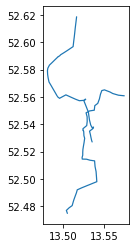

In [7]:
# Plotting the Area of Interest 

aoi_data.plot()

### Checking the Location of the Data using Kepler GL

In [8]:
base_map = KeplerGl(height=600, width=800)
base_map.add_data(data=aoi_data.copy(), name = 'area_of_interest')
base_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'area_of_interest': {'index': [0], 'columns': ['id', 'full_id', 'osm_id', 'osm_type', 'cables',…

### Information Found - Location is North Eastern Part of Berlin, Germany

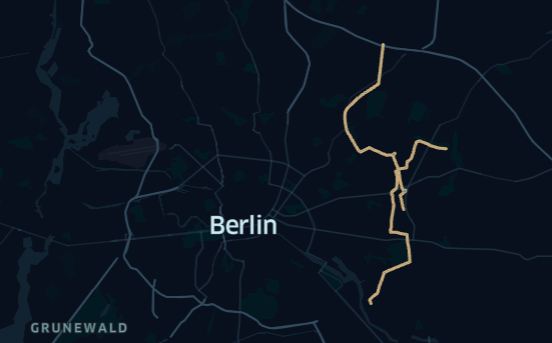

## Processing the Raster Data (Merged - 13 Bands)

In [9]:
raster_folder_path = r'data'
raster_file_name = r'mergedBandswithSCL.tif'
raster_file = os.path.join(raster_folder_path, raster_file_name)
sat_raster12 = rio.open(raster_file)

In [10]:
print('Data type of the file imported',type(sat_raster12))
print('Number of bands in the TIF file is ',sat_raster12.count)
print('CRS is', sat_raster12.crs)

Data type of the file imported <class 'rasterio.io.DatasetReader'>
Number of bands in the TIF file is  13
CRS is EPSG:32633


### Clipping the Raster Data with the AOI

In [11]:
# Taking out the Geometry Shape 
aoi_geom = aoi_data.at[0,'geometry']
type(aoi_geom)

shapely.geometry.multipolygon.MultiPolygon

### I thought of two options to clip the Satellite Image with the AOI Scale (With it's coordinates)
1. Envelope of the AOI
2. Convex Hull of the AOI

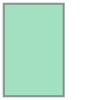

In [12]:
envelope = aoi_geom.envelope
envelope

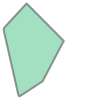

In [13]:
convex_hull = aoi_geom.convex_hull
convex_hull

 ### Assigning the Coordinated Convex Hull and Envelope to the aoi_data for clipping

In [14]:
aoi_data_boundary = aoi_data.copy()

In [15]:
aoi_data_boundary.at[0,'geometry'] = convex_hull
base_map_1 = KeplerGl(height=600, width=800)
base_map_1.add_data(data=aoi_data_boundary.copy(), name = 'area_of_interest')
base_map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'area_of_interest': {'index': [0], 'columns': ['id', 'full_id', 'osm_id', 'osm_type', 'cables',…

In [16]:
aoi_data_boundary.at[0,'geometry'] = envelope
base_map_1 = KeplerGl(height=600, width=800)
base_map_1.add_data(data=aoi_data_boundary.copy(), name = 'area_of_interest')
base_map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'area_of_interest': {'index': [0], 'columns': ['id', 'full_id', 'osm_id', 'osm_type', 'cables',…

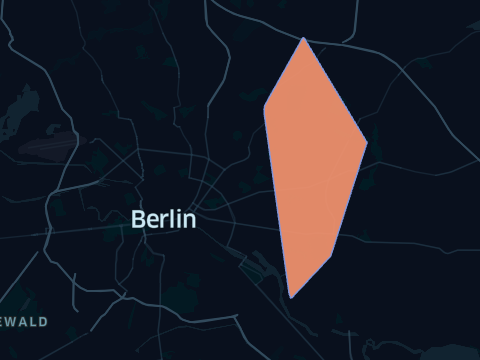

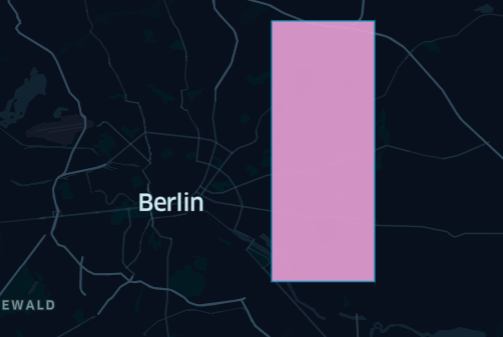

### The Rectagle Boundary looks much better to Clip, so we will go ahead with Envelope of the Coordinates

In [17]:
type(aoi_data_boundary)

geopandas.geodataframe.GeoDataFrame

In [18]:
aoi_data_boundary = aoi_data_boundary.to_crs(sat_raster12.crs)

In [19]:
assertCRSValues(aoi_data_boundary.crs, sat_raster12.crs)

### **Note** : CRS of the Satellite Data, and the Boundary needs to be matched, and hence reprojection was done. 

### Creating the Shape File to Mask the Data using Rasterio. 
Reference was taken from the documentation of [RasterIO API](https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html)

In [20]:
aoi_data_boundary.to_file(r'data\aoi_data_boundary.shp')

C:\TheFourthReich\anaconda3\envs\gisenv\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.


In [21]:
# Opening the Shp file to store the shape for masking
with fiona.open(r"data\aoi_data_boundary.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

In [22]:
from rasterio.mask import mask
out_img, out_transform = mask(dataset=sat_raster12, shapes=shapes, crop=True)

### Copying the MetaData to the New Generated File

In [23]:
out_meta = sat_raster12.meta.copy()
print(out_meta)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 4758, 'height': 4758, 'count': 13, 'crs': CRS.from_epsg(32633), 'transform': Affine(23.076923076923077, 0.0, 300000.0,
       0.0, -23.076923076923077, 5900040.0)}


In [24]:
sat_raster12.crs.data

{'init': 'epsg:32633'}

In [25]:
epsg_code = int(sat_raster12.crs.data['init'][5:])
print(epsg_code)

32633


In [26]:
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
                         )

In [27]:
# Creating the Final Clipped File. 
with rio.open(r'data\clippedGeoTIFF.tif', "w", **out_meta) as dest:
        dest.write(out_img)

In [28]:
# Printing out the Clipped Data for Information
clipped_data = rasterio.open(r'data\clippedGeoTIFF.tif')

print('Data type of the Clipped File',type(clipped_data))
print('Number of bands of the Clipped TIF is ',clipped_data.count)

Data type of the Clipped File <class 'rasterio.io.DatasetReader'>
Number of bands of the Clipped TIF is  13


# Task 1 Clipped Data 

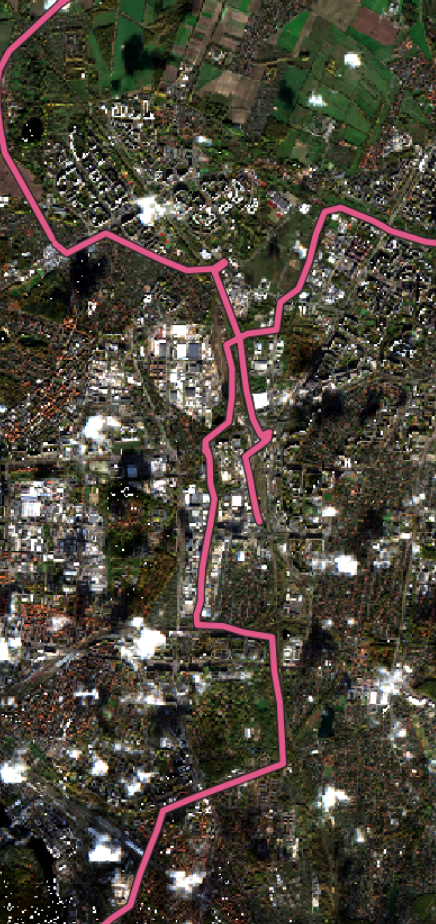

### (Or it can be found in `images\task1_clipped_output.png`)